In [1]:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

import sys
sys.path.append('/home/chris/repos/sentiment_analysis/')

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from credential import * 

def twitter_setup():
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

extractor = twitter_setup()

In [3]:
account = 'regsprecher'

tweets = extractor.user_timeline(screen_name=account, count=1000)
# We print the most recent 5 tweets:
print("5 recent tweets: of "+account)
for tweet in tweets[:5]:
    print(tweet.text)
    print()

5 recent tweets: of regsprecher
RT @AuswaertigesAmt: Die Erneuerung der #Waffenruhe im Osten der #Ukraine ist ein wichtiges Signal. Jetzt kommt es darauf an, dass die Waff…

Kanzlerin #Merkel zu #Digitalisierung und Bürokratieabbau - im aktuellen Podcast vor dem jährlichen Spitzengespräch… https://t.co/71kluIgRpF

RT @AA_SicherReisen: #Ouagadougou. Wir drücken allen Angehörigen der Opfer unser herzliches Beileid aus und wünschen den Verletzten gute Ge…

@clouds_walking Oje. Ich leide mit. Danke für den Hinweis!

Kanzlerin #Merkel telefoniert mit @POTUS Trump. Beide fordern Umsetzung der Resolution des UN-Sicherheitsrates und… https://t.co/L11Fmt5pho



In [4]:

user = extractor.get_user(account)
followers = str(user.followers_count)
print('The account of ' + account + ' has ' + followers +' followers')

The account of regsprecher has 902497 followers


In [5]:
# We create a pandas dataframe as follows:
data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

# We display the first 10 elements of the dataframe:
display(data.head(2))

,Tweets
0,RT @AuswaertigesAmt: Die Erneuerung der #Waffe...
1,Kanzlerin #Merkel zu #Digitalisierung und Büro...


In [6]:
# We print info from the first tweet:
print(tweets[0].id)
print(tweets[0].created_at)
print(tweets[0].source)
print(tweets[0].favorite_count)
print(tweets[0].retweet_count)
print(tweets[0].geo)
print(tweets[0].coordinates)
print(tweets[0].entities)


970687133500559360
2018-03-05 15:47:01
Twitter Web Client
0
23
None
None
{'hashtags': [{'text': 'Waffenruhe', 'indices': [40, 51]}, {'text': 'Ukraine', 'indices': [65, 73]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AuswaertigesAmt', 'name': 'Auswärtiges Amt', 'id': 273468342, 'id_str': '273468342', 'indices': [3, 19]}], 'urls': []}


In [7]:
# We add relevant data:
data['len']  = np.array([len(tweet.text) for tweet in tweets])
data['ID']   = np.array([tweet.id for tweet in tweets])
data['Date'] = np.array([tweet.created_at for tweet in tweets])
data['Source'] = np.array([tweet.source for tweet in tweets])
data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

In [8]:
# We extract the mean of lenghts:
mean = np.mean(data['len'])

print("The lenght's average in tweets: {}".format(mean))

The lenght's average in tweets: 135.28


In [9]:
# We extract the tweet with more FAVs and more RTs:
fav_max = np.max(data['Likes'])
rt_max  = np.max(data['RTs'])

fav = data[data.Likes == fav_max].index[0]
rt  = data[data.RTs == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(data['Tweets'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data['len'][fav]))

# Max RTs:
print("The tweet with more retweets is: \n{}".format(data['Tweets'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data['len'][rt]))

The tweet with more likes is: 
Es lebe die deutsch-französische Freundschaft! 
Vor 55 Jahren wurde der #Élysée-Vertrag unterzeichnet. Heute sagen… https://t.co/ETWuDkZef9
Number of likes: 1403
139 characters.

The tweet with more retweets is: 
Es lebe die deutsch-französische Freundschaft! 
Vor 55 Jahren wurde der #Élysée-Vertrag unterzeichnet. Heute sagen… https://t.co/ETWuDkZef9
Number of retweets: 594
139 characters.



In [10]:
tlen = pd.Series(data=data['len'].values, index=data['Date'])
tfav = pd.Series(data=data['Likes'].values, index=data['Date'])
tret = pd.Series(data=data['RTs'].values, index=data['Date'])

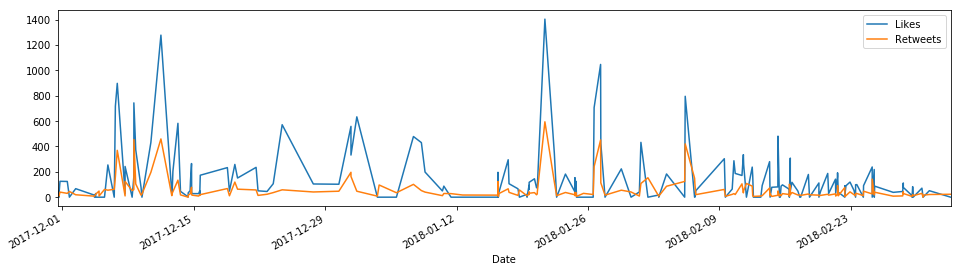

In [11]:
#tlen.plot(figsize=(16,4),label="Length", color='r');
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True)

In [12]:
import scipy

corr_coeff = scipy.stats.pearsonr(tfav, tret)
print('Der Korrelationskoeffizient zwischen Likes und Retweets ist:')
print('------------------------------------------------------------')
print(corr_coeff[0])

Der Korrelationskoeffizient zwischen Likes und Retweets ist:
------------------------------------------------------------
0.849260335911


In [13]:
sources = []
for source in data['Source']:
    if source not in sources:
        sources.append(source)

print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter Web Client
* Twitter for iPad
* Twitter for iPhone
* Media Studio
* TweetDeck


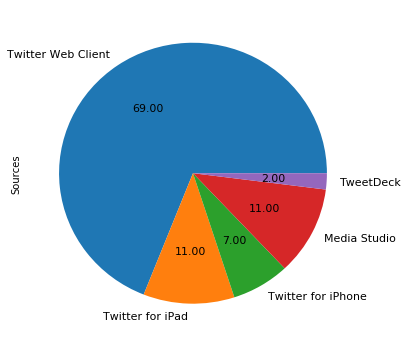

In [14]:
# We create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

In [15]:
from textblob import TextBlob
from textblob_de import TextBlobDE
import re

def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    analysis = TextBlobDE(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [16]:
# We create a column with the result of the analysis:
data['SA'] = np.array([ analize_sentiment(tweet) for tweet in data['Tweets'] ])

In [17]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

### Sentiment results for given account

In [18]:
# We print percentages:

print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data['Tweets'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data['Tweets'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(data['Tweets'])))

Percentage of positive tweets: 30.0%
Percentage of neutral tweets: 63.0%
Percentage de negative tweets: 7.0%


### Create a Wordcloud

In [19]:
from collections import Counter

words = set()
word_counts = data['Tweets'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
#word_counts.Tweets.astype(str)

In [20]:
test = word_counts.to_frame()

In [21]:
'''word_counts = word_counts.fillna('x')
d = {}
for a, x in word_counts.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()'''

'word_counts = word_counts.fillna(\'x\')\nd = {}\nfor a, x in word_counts.values:\n    d[a] = x\n\nimport matplotlib.pyplot as plt\nfrom wordcloud import WordCloud\n\nwordcloud = WordCloud()\nwordcloud.generate_from_frequencies(frequencies=d)\nplt.figure()\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()'

## Analize tweets associated with certain hashtags

In [22]:
MAX_TWEETS = 200
tweet_spd = []
for tweet in tweepy.Cursor(extractor.search, q='#bvb', rpp=100).items(MAX_TWEETS):
    tweet_spd.append(tweet.text)
    pass


In [23]:
data_spd = pd.DataFrame()
data_spd['tweets'] = np.array(tweet_spd)
#data_spd['SA'] = np.array([ analize_sentiment(tweet) for tweet in data_spd['tweets_spd'] ])
data_spd.head(n=3)

,tweets
0,RT @RN_Florian: #BVB-Training läuft. Mit @Raph...
1,"Die Fans, die Dahoud seit Monaten fordern, wer..."
2,RT @BILD_bvb: BVB-Star Pulisic - Für 80 Mio Eu...


### Now calculate the sentiment score for the collected tweets 

In [76]:
data_spd['SA'] = np.array([ analize_sentiment(tweet) for tweet in data_spd['tweets'] ])

In [77]:
# We print percentages:

print("Percentage of positive tweets: {}%".format(data_spd.query('SA>1').shape[0]*100/len(data_spd['tweets'])))
print("Percentage of neutral tweets: {}%".format(data_spd.query('SA==1').shape[0]*100/len(data_spd['tweets'])))
print("Percentage of negative tweets: {}%".format(data_spd.query('SA<1').shape[0]*100/len(data_spd['tweets'])))

Percentage of positive tweets: 0.0%
Percentage of neutral tweets: 31.0%
Percentage of negative tweets: 69.0%


### Compare Google translate vs. Textblob's specific language handling

In [142]:
from googletrans import Translator
translator = Translator()

In [143]:
MAX_TWEETS = 200
tweet_textblob_de = []
tweet_google_translate = []
for tweet in tweepy.Cursor(extractor.search, q='#spd', rpp=100).items(MAX_TWEETS):
    tweet_str = clean_tweet(tweet.text)
    tweet_textblob_de.append(tweet_str)
    #Translate tweet using Google translate
    tweet_google_translate.append(translator.translate(tweet_str).text)
    pass

data_compare = pd.DataFrame()
data_compare['tweets_original'] = tweet_textblob_de
data_compare['tweets_translated'] = tweet_google_translate

In [144]:
def analize_sentiment_german(tweet):
    analysis = TextBlobDE(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
def analize_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [145]:
# We create a column with the result of the analysis:
data_compare['SA_textblob_de'] = np.array([ analize_sentiment_german(tweet) for tweet in data_compare['tweets_original'] ])
data_compare['SA_google_translate'] = np.array([ analize_sentiment(tweet) for tweet in data_compare['tweets_translated'] ])

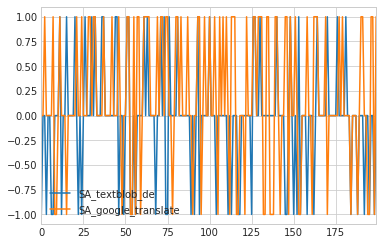

In [146]:
data_compare.plot()

In [147]:
data_compare['SA_textblob_de'].mean()

-0.03

In [148]:
data_compare['SA_google_translate'].mean()

0.175

In [149]:
import scipy

corr_coeff = scipy.stats.pearsonr(data_compare['SA_textblob_de'], data_compare['SA_google_translate'])
print('Der Korrelationskoeffizient zwischen TextBlob_DE und Google Translation ist:')
print('----------------------------------------------------------------------------')
print(corr_coeff[0])

Der Korrelationskoeffizient zwischen TextBlob_DE und Google Translation ist:
----------------------------------------------------------------------------
0.16690992397


### Detect languages used in the tweets

In [150]:
languages = []
def lang_detection(tweet):
    for tweet in tweet_textblob_de:
        lang = translator.detect(tweet).lang
        languages.append(lang)

In [151]:
lang_detection(tweet)
lang_occur = pd.DataFrame()
lang_occur['language'] = languages

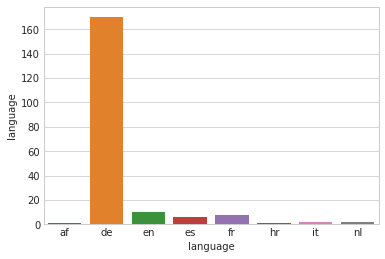

In [152]:
import seaborn as sns
sns.set_style("whitegrid")

sns.barplot(x=lang_occur.groupby('language').size().index, y=lang_occur.groupby('language').language.size())